#  Dodgers Injury Risk Calculator (Bayesian Approach)
This notebook calculates game-by-game injury risk using rolling performance, fatigue indicators, and a Bayesian-style volatility measure, based on the FanGraphs method here: https://community.fangraphs.com/projecting-risk-in-major-league-baseball-a-bayesian-approach/ 

## Imports

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Math

In [2]:
# Connect to SQLite database and load game logs
db_path = '/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/data/dodgers_injury_db.sqlite'
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM game_logs", conn)

In [3]:
# Prepare and sort data
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values(by=['mlb_player_id', 'game_date'])
df['pa'] = df['ab'] + df['bb'] + df['hbp'].fillna(0) + df['sf'].fillna(0)

In [4]:
# Rolling metrics and fatigue
df['rolling_hits'] = df.groupby('mlb_player_id')['h'].transform(lambda x: x.rolling(5, min_periods=1).sum())
df['rolling_abs'] = df.groupby('mlb_player_id')['ab'].transform(lambda x: x.rolling(5, min_periods=1).sum())
df['avg_5g'] = df['rolling_hits'] / df['rolling_abs']
df['days_since_last'] = df.groupby('mlb_player_id')['game_date'].diff().dt.days
df['back_to_back'] = df['days_since_last'] == 1
df['tb_7d'] = df.groupby('mlb_player_id')['tb'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

In [24]:
# Bayesian-style expected TB and volatility
df['hit_rate'] = df['h'] / df['ab'].replace(0, np.nan)
df['tb_per_hit'] = df['tb'] / df['h'].replace(0, np.nan)
df['expected_tb'] = df['hit_rate'] * df['ab'] * df['tb_per_hit']
df['tb_volatility'] = df.groupby('mlb_player_id')['tb'].transform(lambda x: x.rolling(window=7, min_periods=3).std())
df['risk_adjusted_tb'] = (df['tb'] - df['expected_tb']) / df['tb_volatility'].replace(0, np.nan)

In [6]:
# TB vs career average
df['career_avg_tb'] = df.groupby('mlb_player_id')['tb'].transform('mean')
df['tb_vs_career'] = df['tb'] / df['career_avg_tb']

In [7]:
# Composite risk score
df['risk_score'] = (
    df['back_to_back'].astype(int) +
    (df['tb_7d'] > 20).astype(int) +
    (df['avg_5g'] < 0.2).astype(int) +
    (df['risk_adjusted_tb'] < -1).astype(int) +
    (df['tb_vs_career'] < 0.5).astype(int)
)

In [23]:
# Format and export risk table
risk_table = df[[
    'mlb_player_id', 'game_date', 'team', 'opponent',
    'ab', 'h', 'tb', 'avg_5g', 'tb_7d', 'risk_adjusted_tb', 'tb_vs_career',
    'back_to_back', 'risk_score'
]].rename(columns={
    'mlb_player_id': 'Player ID',
    'game_date': 'Game Date',
    'team': 'Team',
    'opponent': 'Opponent',
    'ab': 'At Bats',
    'h': 'Hits',
    'tb': 'Total Bases',
    'avg_5g': '5-Game AVG',
    'tb_7d': '7-Day TB',
    'risk_adjusted_tb': 'Risk-Adj TB',
    'tb_vs_career': 'TB vs Career Avg',
    'back_to_back': 'Back-to-Back Game',
    'risk_score': 'Risk Score'
})

## The Risk Score Tables

In [62]:
player_game_logs = pd.read_sql_query("SELECT players.name, game_logs.* FROM players JOIN game_logs On players.mlb_player_id = game_logs.mlb_player_id ", conn)

nid = player_game_logs[['name', 'mlb_player_id']].drop_duplicates()

nid

,name,mlb_player_id
0,Luis García,472610
20,Kirby Yates,489446
41,Miguel Rojas,500743
67,Freddie Freeman,518692
100,Enrique Hernández,571771
135,Max Muncy,571970
176,Blake Treinen,595014
184,Austin Barnes,605131
197,Mookie Betts,605141
238,Blake Snell,605483


In [10]:
risk_table.head()

,Player ID,Game Date,Team,Opponent,At Bats,Hits,Total Bases,5-Game AVG,7-Day TB,Risk-Adj TB,TB vs Career Avg,Back-to-Back Game,Risk Score
0,472610,2025-03-19,Los Angeles Dodgers,Chicago Cubs,5,2,2,0.400000,2.0,NaN,1.212121,False,0
1,472610,2025-03-28,Los Angeles Dodgers,Detroit Tigers,4,1,3,0.333333,5.0,NaN,1.818182,False,0
2,472610,2025-03-29,Los Angeles Dodgers,Detroit Tigers,7,2,4,0.312500,9.0,0.0,2.424242,True,1
3,472610,2025-03-31,Los Angeles Dodgers,Atlanta Braves,4,1,1,0.300000,10.0,0.0,0.606061,False,0
4,472610,2025-04-04,Los Angeles Dodgers,Philadelphia Phillies,4,0,0,0.250000,10.0,NaN,0.000000,False,1


In [63]:
# find player id 

# Replace  with the plaer name you're looking for
player_name = 'Freddie Freeman'

query = f"""
    SELECT name, mlb_player_id 
    FROM players 
    WHERE name = ?
"""

player_id_df = pd.read_sql_query(query, conn, params=[player_name])
player_id_df

,name,mlb_player_id
0,Freddie Freeman,518692


In [67]:
def get_injury_risk_report(player_id, conn):

    # Load game logs with names
    player_game_logs = pd.read_sql_query("""
        SELECT players.name, game_logs.* 
        FROM players 
        JOIN game_logs 
        ON players.mlb_player_id = game_logs.mlb_player_id
    """, conn)

    # Preprocess
    player_game_logs['game_date'] = pd.to_datetime(player_game_logs['game_date'])
    player_game_logs = player_game_logs.sort_values(by=['mlb_player_id', 'game_date'])

    # Ensure IDs are consistent type
    player_game_logs['mlb_player_id'] = player_game_logs['mlb_player_id'].astype(str)
    player_id = str(player_id)

    # Rolling metrics
    df = player_game_logs.copy()
    df['rolling_so'] = df.groupby('mlb_player_id')['so'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['rolling_obp'] = df.groupby('mlb_player_id')['obp'].transform(lambda x: x.rolling(5, min_periods=1).mean())
    df['rolling_slg'] = df.groupby('mlb_player_id')['slg'].transform(lambda x: x.rolling(5, min_periods=1).mean())

    # Back-to-back indicator
    df['prev_date'] = df.groupby('mlb_player_id')['game_date'].shift(1)
    df['days_between'] = (df['game_date'] - df['prev_date']).dt.days
    df['back_to_back'] = df['days_between'].apply(lambda x: 1 if x == 1 else 0)

    # Fatigue + Injury Risk
    alpha_prior = 1
    beta_prior = 19
    df['fatigue_score'] = (
        0.4 * df['rolling_so'].fillna(0) +
        0.3 * df['back_to_back'].fillna(0) -
        0.15 * df['rolling_obp'].fillna(0) -
        0.15 * df['rolling_slg'].fillna(0)
    )
    df['fatigue_score'] = (df['fatigue_score'] - df['fatigue_score'].min()) / (df['fatigue_score'].max() - df['fatigue_score'].min())
    df['alpha_post'] = alpha_prior + df['fatigue_score']
    df['beta_post'] = beta_prior + (1 - df['fatigue_score'])
    df['injury_risk'] = df['alpha_post'] / (df['alpha_post'] + df['beta_post'])

    # Filter for latest game
    player_df = df[df['mlb_player_id'] == player_id].sort_values('game_date').tail(1)
    if player_df.empty:
        print("No data found for this player.")
        return None

    report = player_df[[
        'name', 'mlb_player_id', 'game_date',
        'rolling_so', 'rolling_obp', 'rolling_slg',
        'back_to_back', 'fatigue_score', 'injury_risk'
    ]].copy()

    report['injury_risk_percent'] = (report['injury_risk'] * 100).round(2).astype(str) + '%'
    print("\nPlayer Injury Risk Breakdown:\n", report)

    # Correlation Heatmap
    corr_df = df[[
        'rolling_so', 'rolling_obp', 'rolling_slg',
        'back_to_back', 'fatigue_score', 'injury_risk'
    ]]
    corr_matrix = corr_df.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
    plt.title("Correlation Matrix: Fatigue Indicators vs Injury Risk", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return report


Player Injury Risk Breakdown:
                name mlb_player_id  game_date  rolling_so  rolling_obp  \
99  Freddie Freeman        518692 2025-05-15         1.0       0.4308   

    rolling_slg  back_to_back  fatigue_score  injury_risk injury_risk_percent  
99       0.7038             1       0.218374     0.058018                5.8%  


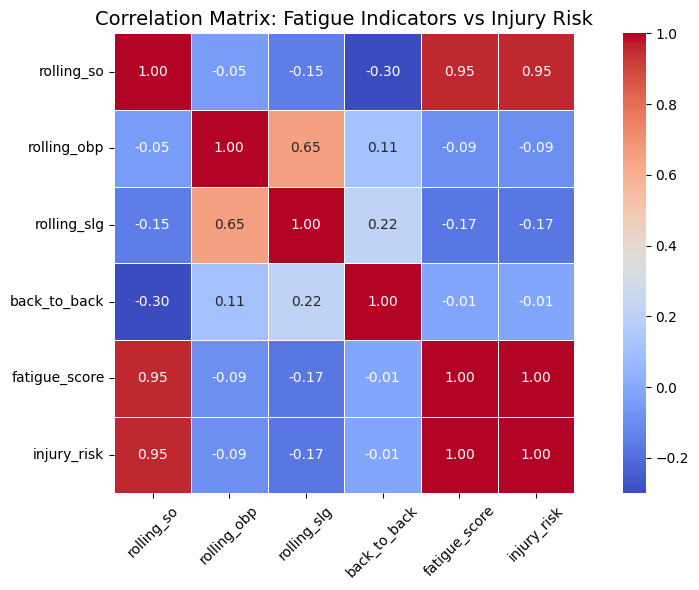

,name,mlb_player_id,game_date,rolling_so,rolling_obp,rolling_slg,back_to_back,fatigue_score,injury_risk,injury_risk_percent
99,Freddie Freeman,518692,2025-05-15,1.0,0.4308,0.7038,1,0.218374,0.058018,5.8%


In [68]:
conn = sqlite3.connect('/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/data/dodgers_injury_db.sqlite')
get_injury_risk_report(518692, conn)

## Players most likely to be injured sorted from most to least


This injury risk model estimates the likelihood of a player getting injured based on recent game performance using a Bayesian approach. It begins by calculating fatigue indicators from each player’s last five games, including average strikeouts (rolling_so), on-base percentage (rolling_obp), slugging percentage (rolling_slg), and whether the player played on back-to-back days. 

These metrics are combined into a weighted fatigue score, which is then normalized between 0 and 1. Using a Bayesian prior that assumes a baseline injury probability of 5% (modeled as Beta(1, 19)), the model updates this belief based on the player’s fatigue score. The result is a personalized injury risk value, with higher risk corresponding to signs of physical strain or performance decline. This allows for dynamic, data-driven tracking of injury likelihood as players accumulate game time.

The injury risk percentages are low by design because the model uses a conservative Bayesian prior that assumes a baseline injury risk of just 5%, reflecting the reality that most players are not injured in any given stretch of games. This prior, represented by a Beta(1, 19) distribution, is only slightly adjusted based on a player’s recent performance trends—such as elevated strikeouts, poor on-base or slugging percentages, and playing on back-to-back days. These factors are combined into a fatigue score, which modifies the prior but does so cautiously to avoid overreacting to short-term fluctuations. As a result, injury risk values typically range from around 5% to 9%, signaling subtle shifts in risk rather than dramatic spikes, unless a player shows multiple signs of fatigue simultaneously.

In [45]:
# 4. Final Output: Latest risk per player
latest_logs = df.sort_values('game_date').groupby('mlb_player_id').tail(1)
risk_report = latest_logs[['name','mlb_player_id', 'game_date', 'injury_risk']].sort_values(by='injury_risk', ascending=False)

# Add a readable percentage column
risk_report['injury_risk_percent'] = (risk_report['injury_risk'] * 100).round(2).astype(str) + '%'

# Optional: Save to CSV
# risk_report.to_csv('injury_risk_report.csv', index=False)

# Print the updated report
risk_report.head(10)

,name,mlb_player_id,game_date,injury_risk,injury_risk_percent
403,Tony Gonsolin,664062,2025-05-11,0.085281,8.53%
498,Bobby Miller,676272,2025-04-16,0.083869,8.39%
610,Yoshinobu Yamamoto,808967,2025-05-14,0.081340,8.13%
410,Dustin May,669160,2025-05-10,0.076016,7.6%
277,Tyler Glasnow,607192,2025-04-27,0.072612,7.26%
516,Justin Wrobleski,680736,2025-05-15,0.070234,7.02%
593,Landon Knack,689017,2025-05-13,0.069969,7.0%
514,Ben Casparius,676508,2025-05-14,0.065591,6.56%
601,Roki Sasaki,808963,2025-05-09,0.064906,6.49%
524,James Outman,681546,2025-05-15,0.061214,6.12%
